In [ ]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "geopandas",
#     "ipywidgets",
#     "lonboard",
#     "numpy",
#     "palettable",
#     "pandas",
#     "shapely",
#     "sidecar",
# ]
# ///

# DataFilterExtension

The `DataFilterExtension` adds GPU-based data filtering functionalities to
layers, allowing the layer to show/hide objects based on user-defined
properties.

In this demo we'll use the `DataFilterExtension` to filter millions of points based on three numeric attributes.


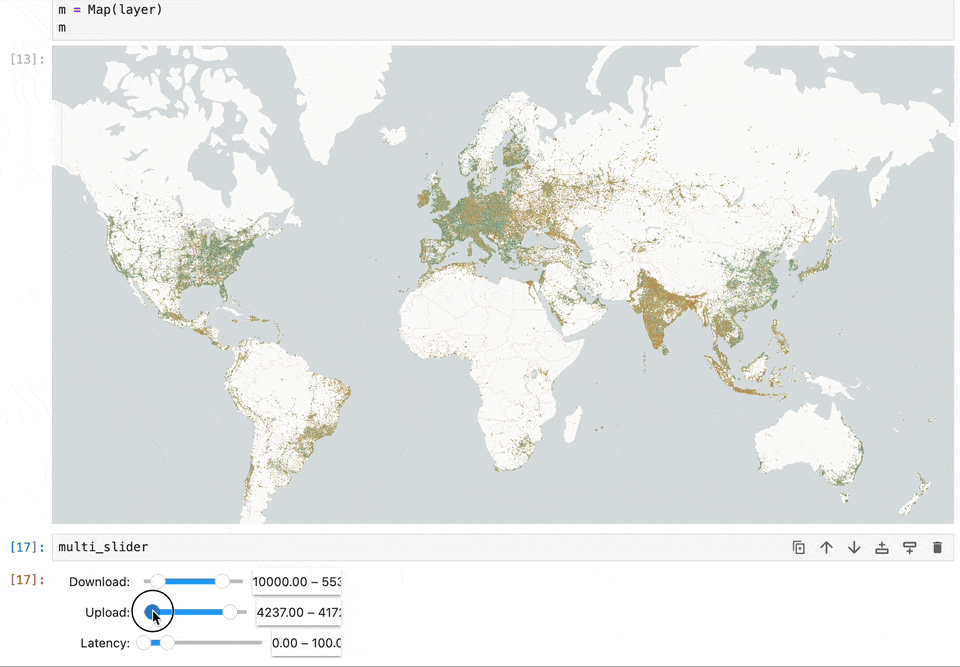


As with the `ScatterplotLayer` example, this example will use data from Ookla's Speed Test application and [shared publicly in the AWS Open Data Registry](https://registry.opendata.aws/speedtest-global-performance/).


## Dependencies

Install [`uv`](https://docs.astral.sh/uv) and then launch this notebook with:

```
uvx juv run examples/data-filter-extension.ipynb
```

(The `uvx` command is included when installing `uv`).


## Imports


In [ ]:
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
from ipywidgets import FloatRangeSlider, jsdlink
from palettable.colorbrewer.diverging import BrBG_10

from lonboard import Map, ScatterplotLayer
from lonboard.colormap import apply_continuous_cmap
from lonboard.controls import MultiRangeSlider
from lonboard.layer_extension import DataFilterExtension

## Fetch data

We use the same data as the `ScatterplotLayer` example except that here we download extra columns from the dataset to use for filtering.

Columns:

- `avg_d_kbps`: the average download speed for that data point in kbps
- `avg_u_kbps`: the average upload speed for that data point in kbps
- `avg_lat_ms`: the average latency for that data point in milliseconds
- `devices`: the number of unique devices contributing tests in the tile.
- `tile`: the WKT string representing a given zoom-16 Web Mercator tile

We cache the downloaded file locally to `data-filter-extension.parquet` so that the second time running this notebook will be faster.


In [ ]:
url = "https://ookla-open-data.s3.us-west-2.amazonaws.com/parquet/performance/type=mobile/year=2019/quarter=1/2019-01-01_performance_mobile_tiles.parquet"
local_path = Path("data-filter-extension.parquet")
if local_path.exists():
    gdf = gpd.read_parquet(local_path)
else:
    columns = ["avg_d_kbps", "avg_u_kbps", "avg_lat_ms", "devices", "tile"]
    df = pd.read_parquet(url, columns=columns)

    tile_geometries = shapely.from_wkt(df["tile"])
    tile_centroids = shapely.centroid(tile_geometries)
    non_geom_columns = [col for col in columns if col != "tile"]
    gdf = gpd.GeoDataFrame(
        df[non_geom_columns],
        geometry=tile_centroids,
        crs="EPSG:4326",
    )
    gdf.to_parquet(local_path)

Taking a quick look at this data, we see that we have 3.2 million records.


In [ ]:
gdf

Since we want to cross-filter on three attributes at once, we create a `DataFilterExtension` instance with `filter_size=3`.


In [ ]:
filter_extension = DataFilterExtension(filter_size=3)

Similar to the `ScatterplotLayer` example notebook, we create a normalized download speed to use for a per-point color and radius.


In [ ]:
min_bound = 5000
max_bound = 50000
normalized_download_speed = (gdf["avg_d_kbps"] - min_bound) / (max_bound - min_bound)
fill_color = apply_continuous_cmap(normalized_download_speed, BrBG_10)
radius = normalized_download_speed * 200

Next we prepare the columns that we want to filter on. In this case, we'll filter on the download speed, upload speed, and latency values. These need to be passed in as a single two-dimensional numpy array, so we use [`numpy.column_stack`](https://numpy.org/doc/stable/reference/generated/numpy.column_stack.html). Only numeric arrays can be used for GPU-based filtering.

We also define initial filter ranges for each of these columns.


In [ ]:
filter_values = np.column_stack(
    [gdf["avg_d_kbps"], gdf["avg_u_kbps"], gdf["avg_lat_ms"]],
)
initial_filter_range = [
    [10_000, 50_000],
    [1000, 10_000],
    [0, 100],
]

Next we create a `ScatterplotLayer` with our desired attributes. Keep in mind that you must pass the `DataFilterExtension` instance to the `extensions` parameter in order to activate its functionality on the layer.


In [ ]:
layer = ScatterplotLayer.from_geopandas(
    gdf,
    extensions=[filter_extension],
    get_fill_color=fill_color,
    get_radius=radius,
    get_filter_value=filter_values,
    filter_range=initial_filter_range,
    radius_units="meters",
    radius_min_pixels=0.1,
)
m = Map(layer)
m

Only the points that are within all of our initial filter ranges are shown, but we'd like something more interactive. Let's connect sliders to the map.

Here we create a separate slider for each attribute and then connect them using a `MultiRangeSlider`. This _defines_ the slider element but it won't be connected to the map until we use `ipywidgets.jsdlink` later.


In [ ]:
download_slider = FloatRangeSlider(
    value=initial_filter_range[0],
    min=0,
    max=70_000,
    step=0.1,
    description="Download: ",
)
upload_slider = FloatRangeSlider(
    value=initial_filter_range[1],
    min=0,
    max=50_000,
    step=1,
    description="Upload: ",
)
latency_slider = FloatRangeSlider(
    value=initial_filter_range[2],
    min=0,
    max=500,
    step=1,
    description="Latency: ",
)
multi_slider = MultiRangeSlider([download_slider, upload_slider, latency_slider])
multi_slider

In order to propagate the changes in our sliders to the `ScatterplotLayer` instance, we use `jsdlink`. See [Linking Widgets](https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20Events.html#linking-widgets) in the ipywidgets documentation for more info.


In [ ]:
_ = jsdlink((multi_slider, "value"), (layer, "filter_range"))